# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "/home/vitob/git_repositories/CarND-Traffic-Sign-Classifier-Project/train.p"
testing_file = "/home/vitob/git_repositories/CarND-Traffic-Sign-Classifier-Project/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
import numpy as np

### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = np.shape(X_train)[0]

# TODO: Number of testing examples.
# <<JC>> Interesting... len shows the first element of np.shape()
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train)[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

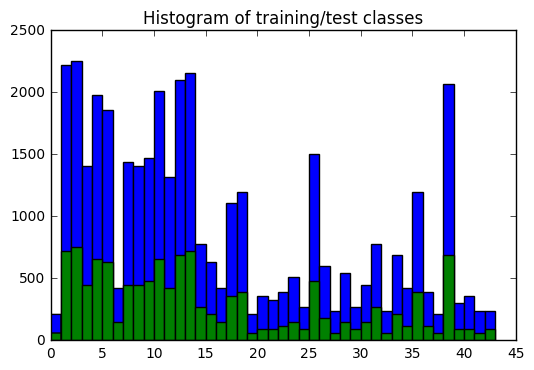

Snapshot of samples from training dataset:


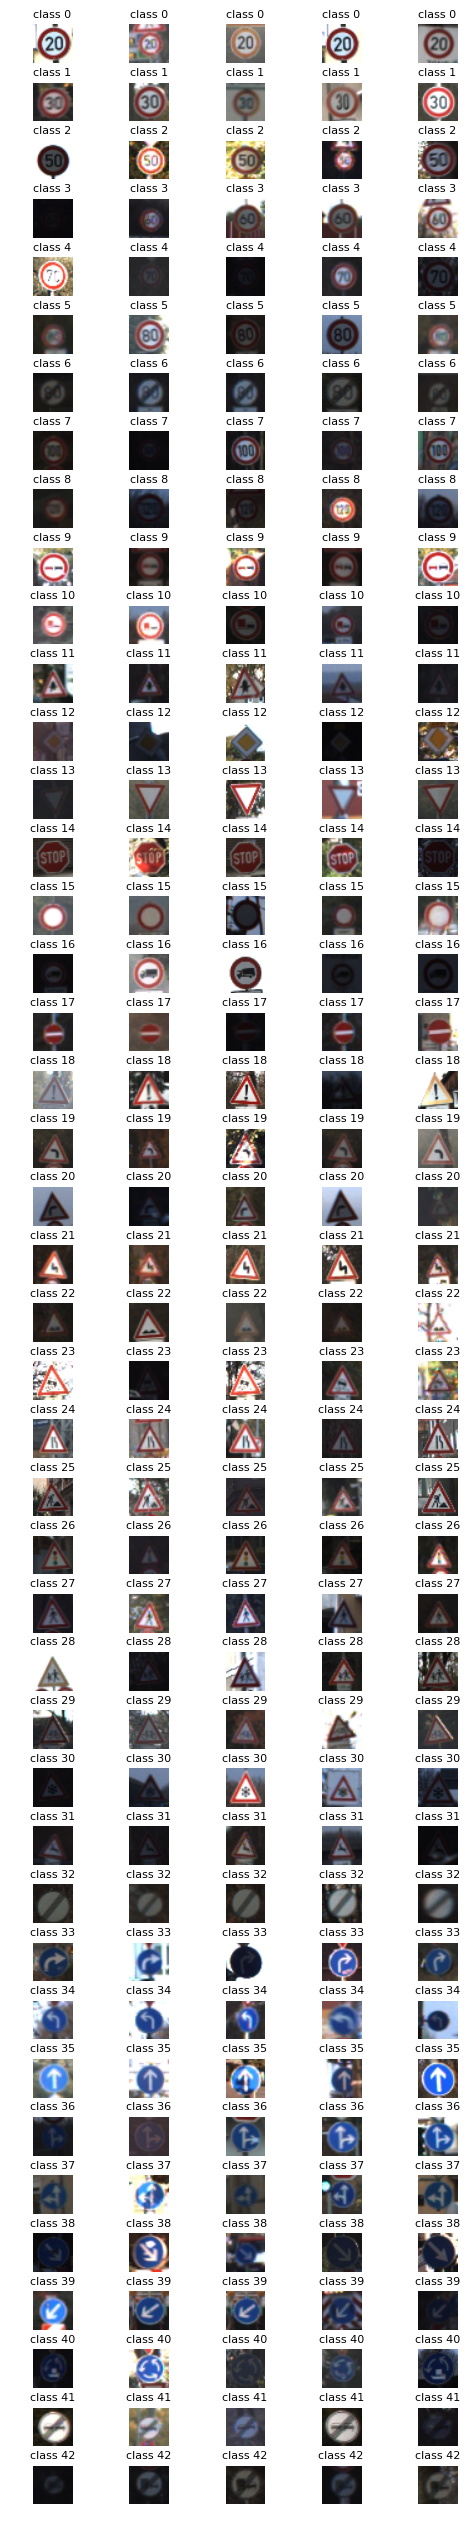

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

# Show histograms of all classes in training dataset
plt.hist(y_train,range(n_classes+1))
plt.hist(y_test,range(n_classes+1))
plt.title("Histogram of training/test classes")
plt.show()

# Show a random of n example of each class
samples_per_class = 5

plt.figure(figsize = (6,32))
print('Snapshot of samples from training dataset:')
for i in range(n_classes):
    idxs = np.random.choice(np.flatnonzero(y_train==i), samples_per_class)
    for j , idx in enumerate(idxs):
        plt_idx = i*samples_per_class + j + 1
        ax = plt.subplot(43, samples_per_class, plt_idx)
        ax.set_title('class '+str(i), fontsize=8)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
plt.subplots_adjust(hspace = 0.5)     
plt.show()
    
    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### 1. Data pre-processing:


In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm

import os
import pickle
from sklearn.utils import shuffle

### Preprocess the data here.

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    img_max = np.max(image_data)
    img_min = np.min(image_data)
    a = 0.1
    b = 0.9

    img_normed = a + (b-a)*(image_data - img_min)/(img_max - img_min)
    #print(np.max(img_normed))
    #print(np.min(img_normed))
    return img_normed

def normalize_color(image_data):
    """
    Normalize the image data on per channel basis. 
    """
    img_normed_color = np.zeros_like(image_data, dtype=float)
    for ch in range(image_data.shape[3]):
        tmp = normalize_grayscale(image_data[:,:,:,ch])
        img_normed_color[:,:,:,ch] = tmp
    #print(np.max(img_normed_color))
    #print(np.min(img_normed_color))
    return img_normed_color

# Shuffle training data
X_train, y_train = shuffle(X_train, y_train)

# Image normalization
X_train_p = normalize_color(X_train)
X_test_p = normalize_color(X_test)

# Labels binarization encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train_p = encoder.transform(y_train)
y_test_p  = encoder.transform(y_test)


# Split half test samples to be validation samples. - Reshuffle included already.
#Thus train/validation/test = 75%/12.5%/12.5%
X_valid_p, X_test_p, y_valid_p, y_test_p = train_test_split(
    X_test_p,
    y_test_p,
    test_size=0.5,
    random_state = 66)

# Save the data for easy access
pickle_file = 'preprocessed.pickle'
if not os.path.isfile(pickle_file):
    print('Saving preprocessed data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': X_train_p,
                    'train_labels': y_train_p,
                    'valid_dataset': X_valid_p,
                    'valid_labels': y_valid_p,
                    'test_dataset': X_test_p,
                    'test_labels': y_test_p,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')



Data cached in pickle file.


### 2. Dataset class
- Retrieving pre-processed pickle file. 
- Function to load train/val/test batch.

In [5]:
import pickle
import numpy as np

class dataset():
    """
    Dataset class to retrieve pickle file, and
    provide function to load train/val batch, test data.
    """
    def __init__(self):
        self.train_pointer = 0

    def reset_ptr(self):
        """
        Reset pointers for new epoch.
        """
        self.train_pointer = 0
        
    def open_dataset(self, file):
        self.f = open(file, 'rb')
        data = pickle.load(self.f)
        self.train_dataset = data['train_dataset']
        self.train_labels = data['train_labels']
        self.valid_dataset = data['valid_dataset']
        self.valid_labels = data['valid_labels']
        self.test_dataset = data['test_dataset']
        self.test_labels = data['test_labels']
        
        self.train_dataset_size = self.train_dataset.shape[0]
        #print("self.train_dataset_size =", self.train_dataset_size)
        
    def close_dataset(self):
        self.f.close()
        
    def steps_per_epoch(self, batch_size):
        assert self.train_dataset_size!=0, "No train dataset exists!"
        return len(self.train_dataset)//batch_size
    
    # Load one batch of training data
    def load_train_batch(self, batch_size):
        if self.train_pointer + batch_size >= self.train_dataset_size:
            # At the end of training dataset items, less than batch_size requested
            batch = self.train_dataset_size
        else:
            # Get next batch_size out
            batch = self.train_pointer + batch_size
            
        X_out = self.train_dataset[self.train_pointer:batch,:,:,:]
        y_out = self.train_labels[self.train_pointer:batch]
        self.train_pointer = batch
        return X_out, y_out, self.train_pointer>=self.train_dataset_size
    
    # Load all train data as a whole
    def load_train_data(self):
        return self.train_dataset, self.train_labels

    # Load all validation data
    def load_valid_data(self):
        # Validation data doesn't need to be loaded in batches.
        return self.valid_dataset, self.valid_labels
    
    # Load all test data
    def load_test_data(self):
        # Test data doesn't need to be loaded in batches.
        return self.test_dataset, self.test_labels



#
# Sanity checks code below 
#
# Load preprocessed data
file = 'preprocessed.pickle'
d = dataset()
d.open_dataset(file)
X_train_batch_1, y_train_batch_1, _ = d.load_train_batch(128)
for i in range(306): # Should report 40 training data, the last batch
    X_train_batch, y_train_batch, runout = d.load_train_batch(128)
    X_valid_batch, y_valid_batch = d.load_valid_data()
    X_test_dataset,  y_test_dataset  = d.load_test_data()

# Debug prints
#print("train_batch[2]=", X_train_batch[2])
#print("train_label[2]=", y_train_batch[2])
print("train_batch.shape = ", X_train_batch.shape)
print("max value in train_batch:", np.max(X_train_batch))
print("min value in train_batch:", np.min(X_train_batch))
print("mean value in train_reset:", np.mean(X_train_batch))
print("train_batch pointer = ", d.train_pointer)
assert runout==True, "ASSERT: Cannot read out all data in training set!!!"

print("validation_batch.shape = ", X_valid_batch.shape)
#print("valid_batch[2]=", X_valid_batch[2])
#print("valid_label[2]=", y_valid_batch[2])
print("max value in validation_batch:", np.max(X_valid_batch))
print("min value in validation_batch:", np.min(X_valid_batch))
print("mean value in validation_batch:", np.mean(X_valid_batch))

print("test_dataset.shape = ", X_test_dataset.shape)
#print("test_dataset[2]=", X_test_dataset[2])
#print("test_label[2]=", y_test_dataset[2])
print("max value in test_dataset:", np.max(X_test_dataset))
print("min value in test_dataset:", np.min(X_test_dataset))
print("mean value in test_dataset:", np.mean(X_test_dataset))

# Reset pointers test
print("Testing dataset.reset_ptr()...")
d.reset_ptr()
X_train_batch_reset, y_train_batch_reset, _ = d.load_train_batch(128)

print("train_batch_reset.shape = ", X_train_batch_reset.shape)
print("max value in train_batch_reset:", np.max(X_train_batch_reset))
print("min value in train_batch_reset:", np.min(X_train_batch_reset))
print("mean value in train_batch_reset:", np.mean(X_train_batch_reset))
print("train_batch pointer = ", d.train_pointer)

assert np.array_equal(X_train_batch_1, X_train_batch_reset), "dataset class reset_ptr() doesn't work!"
assert np.array_equal(y_train_batch_1, y_train_batch_reset), "dataset class reset_ptr() doesn't work!"

d.close_dataset()



train_batch.shape =  (41, 32, 32, 3)
max value in train_batch: 0.9
min value in train_batch: 0.103137254902
mean value in train_reset: 0.365054405814
train_batch pointer =  39209
validation_batch.shape =  (6315, 32, 32, 3)
max value in validation_batch: 0.9
min value in validation_batch: 0.1
mean value in validation_batch: 0.354833402505
test_dataset.shape =  (6315, 32, 32, 3)
max value in test_dataset: 0.9
min value in test_dataset: 0.1
mean value in test_dataset: 0.354736124146
Testing dataset.reset_ptr()...
train_batch_reset.shape =  (128, 32, 32, 3)
max value in train_batch_reset: 0.9
min value in train_batch_reset: 0.1
mean value in train_batch_reset: 0.366120952137
train_batch pointer =  128


### 3. TSC_Net class

The Traffic Sign Classifier (TSC) Neural Network implemention.

In [6]:
# 
# The Traffic Sign Classifier (TSC) Neural Network implemention.

import tensorflow as tf
import numpy as np
import os
import sys
from tensorflow.contrib.layers import flatten

LOG_DIR = './tb_log/WIP'
MODEL_DIR =  './model/WIP'

TRAIN_DROPOUT = 0.5 
TEST_DROPOUT = 1.0


class tsc_net():
    """
    Traffic Sign Classification Network class. Derived from LeNet example.
    """
    
    def __init__(self):
        self.create_tsc_net()
        self.create_tf()
        
        self.session = tf.InteractiveSession()
        
        # Merge all summaries and write them out
        self.merged_summaries = tf.summary.merge_all()

        # Summary saving directories
        if not os.path.exists(LOG_DIR):
            os.makedirs(LOG_DIR)
        train_summary_dir = os.path.join(LOG_DIR, "train")
        test_summary_dir = os.path.join(LOG_DIR, "test")
        if not os.path.exists(train_summary_dir):
            os.makedirs(train_summary_dir)
        if not os.path.exists(test_summary_dir):
            os.makedirs(test_summary_dir)
        self.train_writer = tf.summary.FileWriter(train_summary_dir, self.session.graph)
        self.test_writer = tf.summary.FileWriter(test_summary_dir)
    
        # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
        tf.global_variables_initializer().run()

        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver()

        # Error statistics
        self.err_per_class = np.zeros([43])

    def weight_variable(self,shape,stddev=0.1):
        initial = tf.truncated_normal(shape,stddev=stddev)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.1, shape = shape)
        return tf.Variable(initial)

    def conv2d(self, x, W, b, strides=1):
        # Conv2D wrapper, writh bias and relu activation
        x = tf.nn.conv2d(x, W, strides=[1,strides,strides,1], padding='VALID')
        x = tf.nn.bias_add(x, b)
        #return tf.nn.relu(x)
        x = tf.nn.relu(x)
        return tf.nn.dropout(x, self.keep_prob)
    
    def create_tsc_net(self):   
        """
        Create the tensorflow based layers, cost, optimizer, etc. 
        """
        # Hyperparameters
        mu = 0
        sigma = 0.1

        # Dropout probability
        self.keep_prob = tf.placeholder(tf.float32)
        
        with tf.name_scope("input_layer"):
            # Input layer: [batch_size, 32, 32, 3] - TODO: Tensorflow doesn't support tf.float64 yet.
            self.img_in = tf.placeholder(tf.float32, [None, 32, 32, 3])
            tf.summary.histogram("input_img", self.img_in)
            
        with tf.name_scope("layer1_conv"):
            # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
            conv1_W = self.weight_variable(shape=[5, 5, 3, 12], stddev=sigma)
            conv1_b = self.bias_variable(shape=[12])
            conv1   = self.conv2d(self.img_in, conv1_W, conv1_b)
            tf.summary.histogram("conv1_W", conv1_W)
            tf.summary.histogram("conv1_b", conv1_b)
            tf.summary.histogram("conv1", conv1)
            # Pooling. Input = 28x28x6. Output = 14x14x6.
            conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        with tf.name_scope("layer2_conv"):
            # Layer 2: Convolutional. Output = 10x10x16.
            conv2_W = self.weight_variable(shape=[5, 5, 12, 32], stddev = sigma)
            conv2_b = self.bias_variable(shape=[32])
            conv2   = self.conv2d(conv1, conv2_W, conv2_b)
            tf.summary.histogram("conv2_W", conv2_W)
            tf.summary.histogram("conv2_b", conv2_b)
            tf.summary.histogram("conv2", conv2)
            # Pooling. Input = 10x10x16. Output = 5x5x16.
            conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # Flatten. Input = 5x5x16. Output = 400.
        fc0 = flatten(conv2)

        with tf.name_scope("layer3_fc"):
            # Layer 3: Fully Connected. Input = 400. Output = 120.
            fc1_W = self.weight_variable(shape=[800, 200], stddev = sigma)
            fc1_b = self.bias_variable(shape=[200])
            fc1   = tf.matmul(fc0, fc1_W) + fc1_b
            # Activation.
            fc1    = tf.nn.relu(fc1)
            # Dropout
            fc1_dropout = tf.nn.dropout(fc1, self.keep_prob)
            tf.summary.histogram("fc1_W", fc1_W)
            tf.summary.histogram("fc1_b", fc1_b)
            tf.summary.histogram("fc1", fc1)
            tf.summary.histogram("fc1_dropout", fc1_dropout)
            
        with tf.name_scope("layer4_fc"):
            # Layer 4: Fully Connected. Input = 120. Output = 84.
            fc2_W  = self.weight_variable(shape=[200, 128], stddev = sigma)
            fc2_b  = self.bias_variable(shape=[128])
            fc2    = tf.matmul(fc1_dropout, fc2_W) + fc2_b
            # Activation.
            fc2    = tf.nn.relu(fc2)
            # Dropout
            fc2_dropout = tf.nn.dropout(fc2, self.keep_prob)
            tf.summary.histogram("fc2_W", fc2_W)
            tf.summary.histogram("fc2_b", fc2_b)
            tf.summary.histogram("fc2", fc2)
            tf.summary.histogram("fc2_dropout", fc2_dropout)
            
        with tf.name_scope("layer5_fc"):
            # Layer 5: Fully Connected. Input = 84. Output = 43.
            fc3_W  = self.weight_variable(shape=[128, 43], stddev = sigma)
            fc3_b  = self.bias_variable(shape=[43])
            self.logits = tf.matmul(fc2_dropout, fc3_W) + fc3_b
            tf.summary.histogram("fc3_W", fc3_W)
            tf.summary.histogram("fc3_b", fc3_b)
            tf.summary.histogram("logits", self.logits)
            
    def create_tf(self):
        """
        Loss/accuracy function and optimizer definition.
        """
        self.learning_rate = tf.placeholder(tf.float32)
        self.label_truth = tf.placeholder(tf.float32, [None,43])
        self.loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.logits, self.label_truth))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
        
        #self.prediction = tf.nn.softmax(self.logits)        
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.logits, 1), 
                                    tf.argmax(self.label_truth, 1)), tf.float32))
        
        tf.summary.scalar('loss', self.loss)
        tf.summary.scalar('accuracy', self.accuracy)
        
    def train(self,X,y,lr,i):
        summary, _, loss, accuracy = self.session.run(
                [self.merged_summaries, self.optimizer, self.loss, self.accuracy],
                feed_dict={
                    self.img_in: X.astype(np.float32),
                    self.label_truth: y.astype(np.float32),
                    self.keep_prob: TRAIN_DROPOUT,
                    self.learning_rate: lr
                })
        # Record summary every N batches
        if i%50 == 0:
            #print('training: step {0:5d}, lr {1:8.7f}, accuracy {2:8.2f}%, loss {3:8.2f}'.format(i, lr, accuracy*100, loss))
            self.train_writer.add_summary(summary, i)

    def val(self,X,y,i,summary_on):
        summary, loss, accuracy = self.session.run(
                [self.merged_summaries, self.loss, self.accuracy],
                feed_dict={
                    self.img_in: X.astype(np.float32),
                    self.label_truth: y.astype(np.float32),
                    self.keep_prob: TEST_DROPOUT
                })
        print('validation: step {0:5d}, accuracy {1:8.2f}%, loss {2:8.2f}'.format(i, accuracy*100, loss))
        if summary_on:
            self.test_writer.add_summary(summary, i)
        
    def predict(self,X):
        logits = self.session.run(
                [self.logits],
                feed_dict={
                    self.img_in: X.astype(np.float32),
                    self.keep_prob: TEST_DROPOUT
                })
        # Predict class catogery
        for i in range(len(X)):
            print("Prediction: img {}, class {}".format(i, np.argmax(logits[0][i])))
        return logits
        

    def err_statistics(self,X,y):
        logits = self.session.run(
                [self.logits],
                feed_dict={
                    self.img_in: X.astype(np.float32),
                    self.label_truth: y.astype(np.float32),
                    self.keep_prob: TEST_DROPOUT
                })
        # Error counts per class/category
        for i in range(len(y)):
            if np.argmax(logits[0][i]) != np.argmax(y[i]):
                self.err_per_class[np.argmax(y[i])] += 1
        print('err statistics: err_per_class = {}'.format(self.err_per_class))
        return self.err_per_class

    def saveParam(self):
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        checkpoint_path = os.path.join(MODEL_DIR, "model.ckpt")
        filename = self.saver.save(self.session, checkpoint_path)
        print("Model saved in file: %s" % filename)

    def restoreParam(self):
        if not os.path.exists(MODEL_DIR):
            sys.exit("No such dir to restore parameters! Exiting.")
        checkpoint_path = os.path.join(MODEL_DIR, "model.ckpt")
        self.saver.restore(self.session, checkpoint_path)
        print("Model restored from file: %s" % checkpoint_path)





### 4. Stitching everthing together

In [7]:
# ### 4. Stitching everthing together

import numpy as np

EPOCH = 50
BATCH_SZ = 256
LEARNING_RATE = 8e-4
DECAY_LR = 1.0


def main():
    mynet = tsc_net()
    data = dataset()

    file = 'preprocessed.pickle'

    data.open_dataset(file)

    # Training
    lr = LEARNING_RATE
    for j in range(EPOCH):
        steps_per_epoch = data.steps_per_epoch(BATCH_SZ)
        print("Epoch {0:4d}, Steps per epoch {1:5d}".format(j, steps_per_epoch))
        for i in range(steps_per_epoch):
            X_train_batch, y_train_batch, end_of_train_dataset = data.load_train_batch(BATCH_SZ)
            if i==0 and j==0 :
                print("X_train_batch.shape = ", np.shape(X_train_batch))
                print("X_train_batch.dtype = ", X_train_batch.dtype)
                print("y_train_batch.shape = ", np.shape(y_train_batch))
                print("y_train_batch.dtype = ", y_train_batch.dtype)
            if i%500 == 0:
                    lr = lr*DECAY_LR
            mynet.train(X_train_batch, y_train_batch, lr, j*steps_per_epoch+i)

        # Validation dataset
        X_valid_dataset, y_valid_dataset = data.load_valid_data()
        mynet.val(X_valid_dataset, y_valid_dataset, j*steps_per_epoch+i, True)

        # Reset pointers test
        #print("Testing dataset.reset_ptr()...")
        data.reset_ptr()

    # Test dataset
    X_test_dataset,  y_test_dataset  = data.load_test_data()
    mynet.val(X_test_dataset, y_test_dataset, j*steps_per_epoch+i, True)

    # Error category statistics
    mynet.err_statistics(X_test_dataset, y_test_dataset)

    data.close_dataset()

    mynet.saveParam()

if __name__ == '__main__':
    main()




Epoch    0, Steps per epoch   153
X_train_batch.shape =  (256, 32, 32, 3)
X_train_batch.dtype =  float64
y_train_batch.shape =  (256, 43)
y_train_batch.dtype =  int64
validation: step   152, accuracy    40.00%, loss     2.75
Epoch    1, Steps per epoch   153
validation: step   305, accuracy    58.70%, loss     1.82
Epoch    2, Steps per epoch   153
validation: step   458, accuracy    72.67%, loss     1.35
Epoch    3, Steps per epoch   153
validation: step   611, accuracy    80.84%, loss     1.04
Epoch    4, Steps per epoch   153
validation: step   764, accuracy    84.99%, loss     0.83
Epoch    5, Steps per epoch   153
validation: step   917, accuracy    88.00%, loss     0.73
Epoch    6, Steps per epoch   153
validation: step  1070, accuracy    88.50%, loss     0.62
Epoch    7, Steps per epoch   153
validation: step  1223, accuracy    90.02%, loss     0.58
Epoch    8, Steps per epoch   153
validation: step  1376, accuracy    90.20%, loss     0.49
Epoch    9, Steps per epoch   153
valid

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
- Image normalization across three channels (RGB) individually. This is required to make sure input data is within a well constrained small number range [0.1,0.9] so that we have data stability. 
- Then I shuffled the data using sklearn train_test_split() so that they randomly distribute to avoid overfitting problem in training process. 

I've run out of time for this project, that I would have tested these data augumentation:
##TODO : Create more data for general application
- Wrap images
- Add noises to images
- Image occlusion
- Brightness/Contrast 
- Scale of the traffic sign, but to a limit when shrinking.

I did try to normalize input to [-0.4, 0.4] so that mean=0, but it seems not much difference comparing to [0.1,0.9] I noticed the 1st layer just offset the bias with layer_1/conv1_b. Below figures show that. 

<img src="biased_normalization.png">


In [8]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
Since the histogram distribution across different categories are extremely similar between provided training/testing dataset, I keep all training data as training input and split half-half in provided testing dataset to be validation and test input.

Running out of time to generate more data. If time allows, I'd like to add more samples into training dataset with fewer instances in training (low bar in histogram) but with high failure rate in prediction, namely, class 0, 21, 29, 41. 

<img src="train_data_vs_err_histogram.png">

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In a summary, roughly 2x wider of each layer of original LeNet (CNN). 

- Layer 1, convolution w/ relu/dropout/2x pooling, input size = 32x32x3, conv filter size = 5x5x3x12, output = 14x14x12
- Layer 2, convolution w/ relu/dropout/2x pooling, conv filter size = 5x5x12x32, output = 5x5x32
- Layer 3, fully connected w/ relu/dropout, filter size = 800x200
- Layer 4, fully connected w/ relu/dropout, filter size = 200x128
- Layer 5, output layer, filter size = 128x43


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I did a grid search of parameters over parameters. * represents the option selected finally.
- AdaOptimization
- Batch size: 64, 128, *256, 512
- Linear decaying learning rate (0.98): ON/*OFF (not much difference)
- Drop out only on FC layers or all layers including conv layers. *Latter increased accuracy ~1%.

<img src="training_grid_search.png">

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

- Started with LeNet architecture. Grid search across different learning rate, batch_size, epoch. Best combinations: LR=~1e-3, batch_size=256, epoch>=40. ~90% accuracy
- Overfitting witnessed in train/validation accuracy/loss gap. 
- To deal with overfitting, I added dropout to FC layers only. Grid search again. Dropout helps.
- Added dropout to CONV layers too, running grid search against FC_layer-only-dropout, found it is helpful. Keep it. ~93.5% accuracy.
- To add L2 regularization might help further, but I didn't try as the gap between train/valid loss is small now.
- Extend the width of LeNet to roughly 2x wide to provide more capability of representation. It helped! Now accuracy at about 96% with 100 epoches. 

TODO: I ran out of time, so below are for records now. 

- I draw the err_cnt vs. class category chart as below. Interesting finding is that class 0-9, and class 25-30 are error prone. 
- Class 0-9 are speed limit signs, they are so similar in round shape and only difference is inside figures. Some better feature representation to differentiate that in data preprocessing should help.
- Class 25-30 are simiar with triagle shape and need feature extract to differentiate the internals inside triangle. 
- Class 13 and 18?
- Why train/valid behavior different for class 7 and 21?
- Data imbalance pre-processing.
<img src="err_cnt_vs_total.png">

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Snapshot of samples from internet:


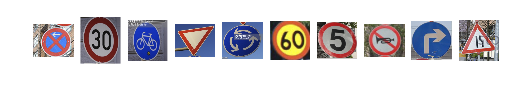

In [2]:
### Load the images and plot them here.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Visualizations will be shown in the notebook.
%matplotlib inline

# Show a random of n example of each class
samples_per_class = 5

plt.figure(figsize = (6,32))
print('Snapshot of samples from internet:')
idx=0
for img in range(10):
    idx += 1
    ax = plt.subplot(1, 10, idx)
    plt.imshow(mpimg.imread('internet_traffic_signs/'+str(img)+'.png'))
    plt.axis('off')
plt.subplots_adjust(hspace = 0.5)     
plt.show()



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Out of the 6 selected images:
- First two (class 1/13) are of special interest to test whether the trained net is vulnerable to warped images, as these two images were taken from side ways.
- Third and last images (class 40/24) is to test occlusion or graffiti, as there's letters overley on the image

Choose 6 images from above for prediction:


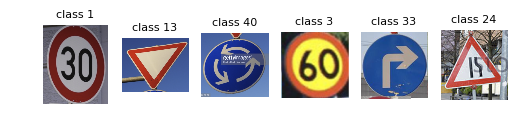

In [3]:
# Choose 6 images from above for prediction
print('Choose 6 images from above for prediction:')
idx=0
class_list = [1,13,40,3,33,24]
for img in list([1,3,4,5,8,9]):
    idx += 1
    ax = plt.subplot(1, 6, idx)
    plt.imshow(mpimg.imread('internet_traffic_signs/'+str(img)+'.png'))
    ax.set_title('class '+str(class_list[idx-1]), fontsize=8)
    plt.axis('off')
plt.subplots_adjust(hspace = 0.5)     
plt.show()

In [4]:
### Run the predictions here.
#
# Predict class of traffic sign images from internet
#
from tsc import tsc_net
from dataset import dataset
import numpy as np
import cv2

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    img_max = np.max(image_data)
    img_min = np.min(image_data)
    a = 0.1
    b = 0.9

    img_normed = a + (b-a)*(image_data - img_min)/(img_max - img_min)
    #print(np.max(img_normed))
    #print(np.min(img_normed))
    return img_normed

def normalize_color(image_data):
    """
    Normalize the image data on per channel basis. 
    """
    img_normed_color = np.zeros_like(image_data, dtype=float)
    for ch in range(image_data.shape[3]):
        tmp = normalize_grayscale(image_data[:,:,:,ch])
        img_normed_color[:,:,:,ch] = tmp
    #print(np.max(img_normed_color))
    #print(np.min(img_normed_color))
    return img_normed_color

# Create TSC NN and restore trained parameters
mynet=tsc_net()
mynet.restoreParam()



Model restored from file: ./model/2xLeNet_256_8e-4_dropout/model.ckpt


Choose 6 images from above for prediction:


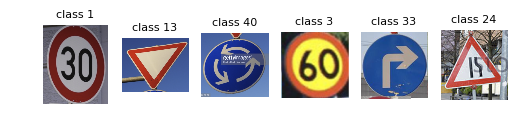

Prediction: img 0, class 1
Prediction: img 1, class 13
Prediction: img 2, class 9
Prediction: img 3, class 32
Prediction: img 4, class 9
Prediction: img 5, class 26


In [5]:
# Choose 6 images from above for prediction
print('Choose 6 images from above for prediction:')
idx=0
class_list = [1,13,40,3,33,24]
for img in list([1,3,4,5,8,9]):
    idx += 1
    ax = plt.subplot(1, 6, idx)
    plt.imshow(mpimg.imread('internet_traffic_signs/'+str(img)+'.png'))
    ax.set_title('class '+str(class_list[idx-1]), fontsize=8)
    plt.axis('off')
plt.subplots_adjust(hspace = 0.5)     
plt.show()

# Choose 6 images from above for prediction# Load internet images and make prediction
img_in = np.zeros([6,32,32,3])
for i,idx in zip(list([1,3,4,5,8,9]),range(6)):
    img=cv2.imread('./internet_traffic_signs/'+str(i)+'.png')
    img = cv2.resize(img,(32,32))
    img = img.reshape(-1,32,32,3)
    # Normalize the image between [0.1, 0.9]
    img_in[idx] = normalize_color(img)

# Predict
certainty = mynet.predict(img_in)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
NO, it only achieved 33% accuracy out from the captured pictures from internet, in comparison to ~96% accuracy rate on testing data. The trained network is showing apparent overfitting on testing data. 

Class 40/3/33/24 all failed. 

- The trained net is not vulnerable to warped images as both class 1/13 passed.
- It is definitely vulnerable to graffiti or occlusion on signs. Proved by class 40/24 images.
- I cannot figure out completely why class 3/33 failed. 
-- Class 3: background in side the circle of this image is yellow while training set images are all white.
-- Class 33: Watching closely, this sign is actually different from training set. It has a sharper turn before the arrow. So it explains. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The trained net is very certain about first two images, and it is correct in classification for these two images. 

It is also kind of certain of the rest 4 images, but all are incorrect. Details in below charts. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

Certainty percentage: 99.82%


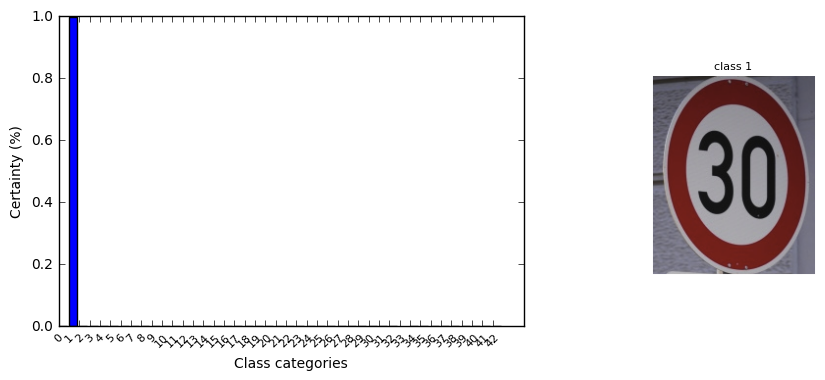

Certainty percentage: 100.00%


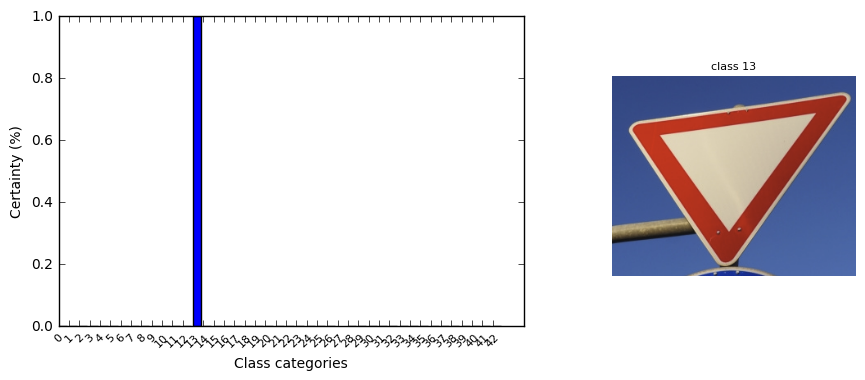

Certainty percentage: 60.52%


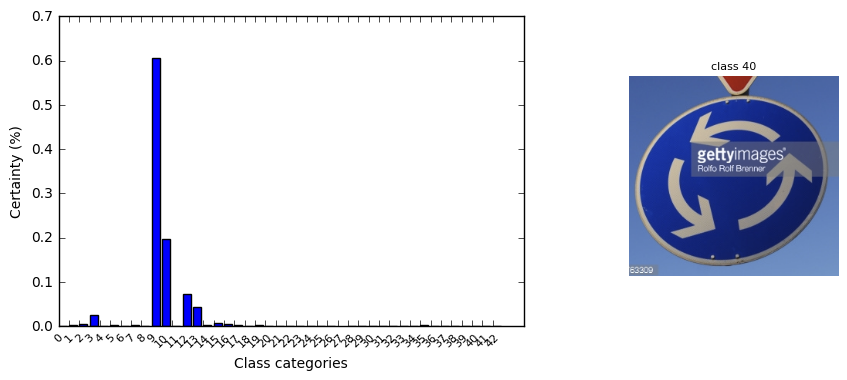

Certainty percentage: 31.06%


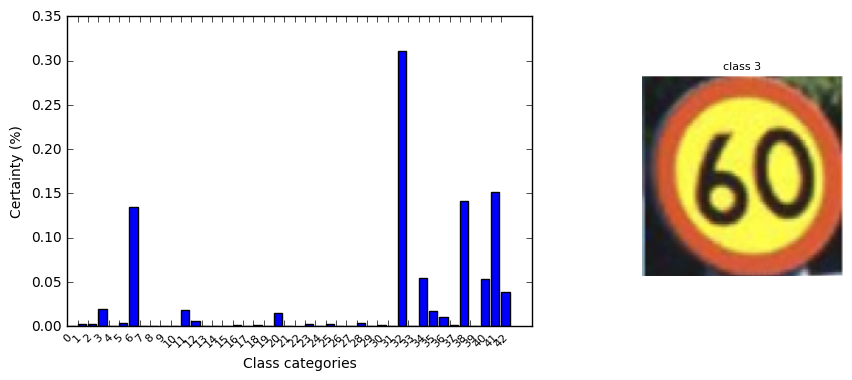

Certainty percentage: 26.03%


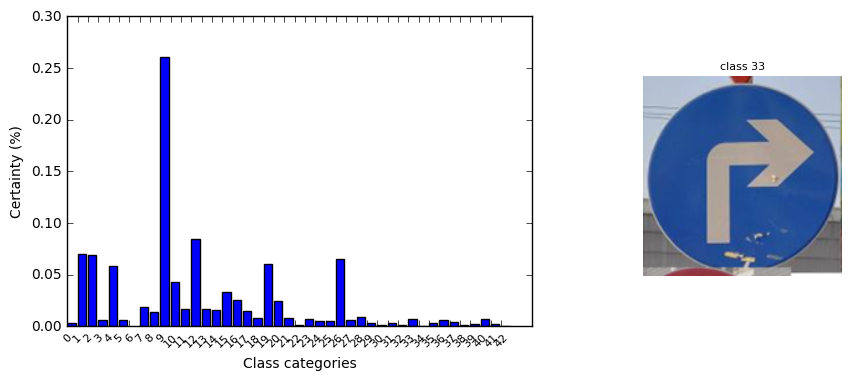

Certainty percentage: 64.02%


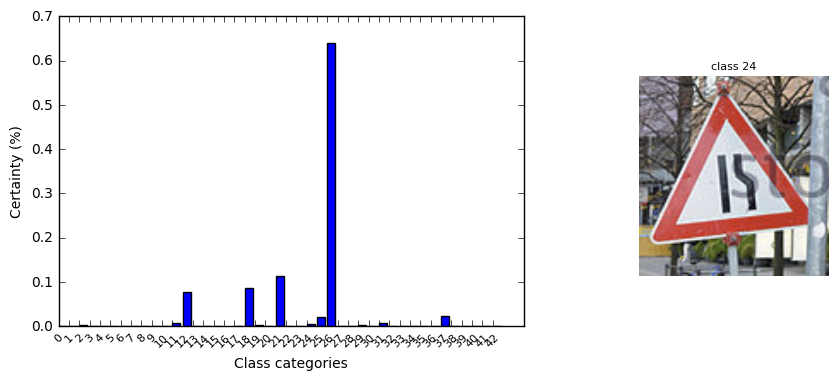

In [6]:
import tensorflow as tf

sess = tf.Session()
top_pred, top_indice = sess.run(tf.nn.top_k(certainty[0], k=42))

class_list = [1,13,40,3,33,24]

#print(top_pred, top_indice)
for i,img in zip(range(6), list([1,3,4,5,8,9])):
    plt.bar(top_indice[i], top_pred[i])
    tmp = 100*(top_pred[i][0])/sum(top_pred[i])
    plt.xticks(np.arange(0,43,1.0),rotation=45, fontsize=8)
    plt.ylabel('Certainty (%)')
    plt.xlabel('Class categories')

    ax = plt.axes([1.0,.25,.5,.5], frameon=True)
    ax.imshow(mpimg.imread('internet_traffic_signs/'+str(img)+'.png'))
    ax.set_title('class '+str(class_list[i]), fontsize=8)
    ax.axis('off')
    print('Certainty percentage: {0:4.2f}%'.format(tmp))
    plt.show()